In [1]:
import math 
import sys
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler
from utils import *
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [2]:
''' 
    Read one week of data 
'''
week = 1

# Format the week with leading zeros
number = f"{week:02d}"

# Path of file
base_path = f"data/X{number}/X{number}"

# Load file
data = np.loadtxt(base_path)

# Keep first 144 entries from each line 
data = data[:, :144]

In [3]:
# Normalize the data
scaler = MinMaxScaler()
data_norm = normalize_matrix(scaler, data)

# Train-Test Split 
train_data, test_data = train_test_split(data_norm, 0.8)

# Window the dataset
trainX, trainY = create_dataset(train_data, 10)
testX, testY = create_dataset(test_data, 10)

In [4]:
# Specify model parameters 
input_size = trainX.shape[2] # Number of features in input
hidden_size = 200  # Number of features in hidden state
output_size = 144  # Number of output classes 
learn_rate = 0.001 
epochs = 100
num_layers = 1
batch_size = 32
shuffle = False #don't want to lose the time dependency
num_workers = 4  # Number of subprocesses to use for data loading

In [5]:
# create torch datasets and torch dataloader

train_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(trainX),
                                                 torch.Tensor(trainY))


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                             num_workers=num_workers,
                                             shuffle=shuffle)

test_dataset  = torch.utils.data.TensorDataset(torch.FloatTensor(testX),
                                                 torch.Tensor(testY))


test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1,
                                             num_workers=num_workers,
                                             shuffle=shuffle)


In [6]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(RNN, self).__init__()

        self.rnn = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )
        self.sigmoid = nn.Sigmoid()
        self.out = nn.Linear(hidden_size, input_size)

    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        r_out, _ = self.rnn(x, None)  # None represents zero initial hidden state
        out = self.out(r_out[:, -1, :])  # return the last value
        out = self.sigmoid(out)
        return out

In [7]:
'''
The loss function in Prophet is 1 - x^T.Y/|X|_2|Y|_2
'''

class CosineSim(nn.Module):
    def __init__(self):
        super(CosineSim, self).__init__()

    def forward(self, inputs, targets):
        loss = 0
        for i in range(inputs.shape[0]):
            input = inputs[i]
            target = targets[i]

            norm1 = torch.sqrt(torch.sum(torch.square(input)))
            norm2 = torch.sqrt(torch.sum(torch.square(target)))

            loss+= 1 - (torch.dot(input, target)/(norm1*norm2))

        loss /= inputs.shape[0]
        
        return loss

In [8]:
import time

# Define training function

def train(model, train_loader, epochs, criterion, optimizer):
    ''' Train ML Model''' 

    print_interval = 5
    track_losses = np.zeros(epochs)
    start = time.time()

    for epoch in range(epochs): 
        for inputs, targets in train_loader: 
            
            # Pass data to LSTM
            optimizer.zero_grad()
            outputs = model(inputs)
            
            # Compute the loss
            loss = criterion(outputs, targets)

            # Compute the gradient and update the network parameters
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        training_loss = loss.item()
        track_losses[epoch] = training_loss 

        if (epoch) % (print_interval-1) == 0:
            print('epoch: %4d training loss:%10.3e time:%7.1f'%(epoch, training_loss, time.time()-start))

    return track_losses

In [9]:
# Create Model 
model = RNN(input_size, hidden_size, num_layers)

# Create optimizer 
optimizer = optim.Adam(model.parameters(), lr=learn_rate)

# Create loss function
criterion = CosineSim()

In [10]:
# Train the model
loss = train(model, train_loader, epochs, criterion, optimizer)

epoch:    0 training loss: 1.192e-01 time:   12.0
epoch:    4 training loss: 7.956e-02 time:   60.5
epoch:    8 training loss: 7.128e-02 time:  109.0
epoch:   12 training loss: 6.792e-02 time:  152.5
epoch:   16 training loss: 6.307e-02 time:  193.9
epoch:   20 training loss: 4.991e-02 time:  225.7
epoch:   24 training loss: 3.578e-02 time:  263.4
epoch:   28 training loss: 3.322e-02 time:  320.1
epoch:   32 training loss: 2.294e-02 time:  367.9
epoch:   36 training loss: 1.052e-02 time:  399.8
epoch:   40 training loss: 7.799e-03 time:  431.4
epoch:   44 training loss: 5.745e-03 time:  462.7
epoch:   48 training loss: 4.312e-03 time:  493.3
epoch:   52 training loss: 3.230e-03 time:  524.2
epoch:   56 training loss: 1.982e-03 time:  555.4
epoch:   60 training loss: 1.805e-03 time:  586.9
epoch:   64 training loss: 1.705e-03 time:  618.2
epoch:   68 training loss: 1.466e-03 time:  649.4
epoch:   72 training loss: 1.189e-03 time:  681.2
epoch:   76 training loss: 1.140e-03 time:  720.3


Text(0.5, 1.0, 'Training Loss vs. Epochs')

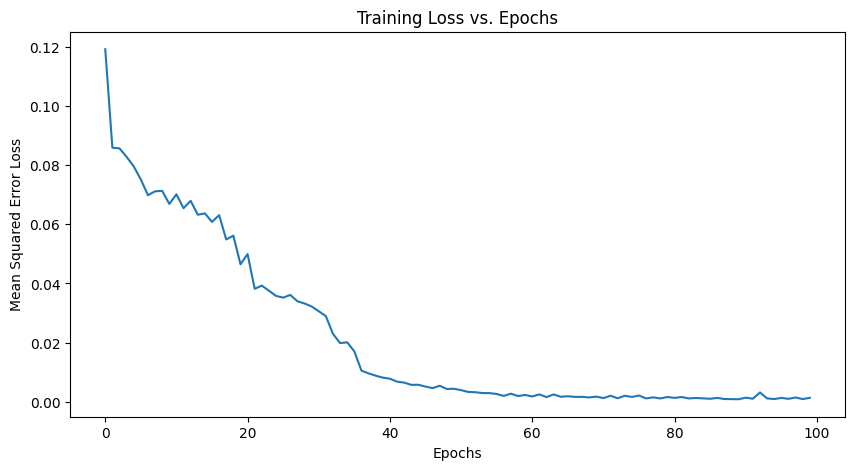

In [11]:
# Plot training loss 
fig, ax = plt.subplots(figsize = (10,5))
ax.plot(range(epochs), loss)

# Label Figure
ax.set_xlabel('Epochs')
ax.set_ylabel('Mean Squared Error Loss')
ax.set_title('Training Loss vs. Epochs')

In [12]:
# Define testing function
def test(model, criterion, test_loader, testY): 
    
    ''' Test ML Model '''
    
    model.eval() # Put model in eval mode 
    total_loss = 0.0 
    num_samples = 0 

    model_outputs = np.zeros((testY.shape[0], testY.shape[1]))
    test_loss = np.zeros((testY.shape[0], 1))

    with torch.no_grad():
        for idx, (inputs, targets) in enumerate(test_loader): 
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item() * inputs.size(0)  # Multiply by batch size
            model_outputs[idx, :] = outputs # Store outputs
            
    return model_outputs, test_loss

In [13]:
model_outputs, test_loss = test(model, criterion, test_loader, testY)

C:\Users\marth\AppData\Local\Temp\ipykernel_26012\1239243096.py:20: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  model_outputs[idx, :] = outputs # Store outputs


In [14]:
# Use test data from the original dataset. We can do the inverse transform, but it won't be 100% accurate. 
_, test_set = train_test_split(data, 0.8)

preds = np.empty(model_outputs.shape)

for i in range(len(test_set)-10):
    scaler = MinMaxScaler()
    _ = scaler.fit_transform(test_set[i, :].reshape(-1, 1))

    preds[i, :] = scaler.inverse_transform(model_outputs[i,:].reshape(1, -1))


# Save predictions 
np.save('preds_abilene_cosine_baseline.npy', preds)

Text(440, 50, 'NMSE: 0.134')

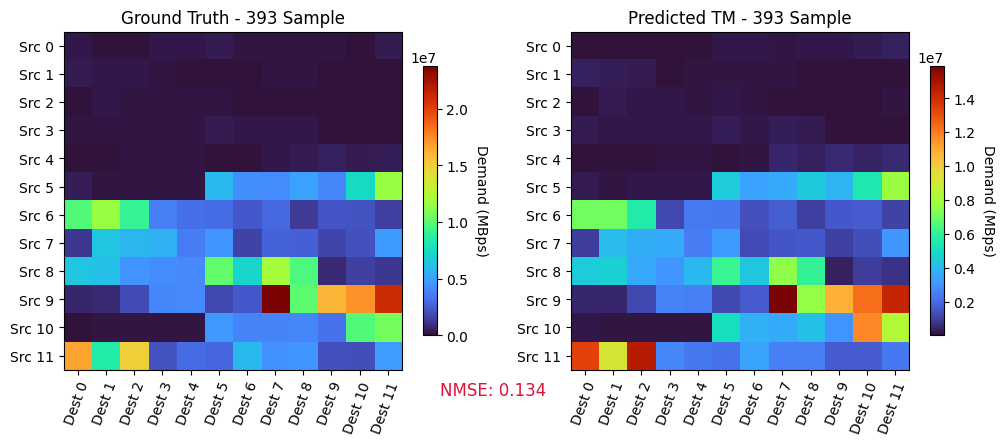

In [15]:
# Visual comparison of model outputs and ground truth
sources = ['Src {}'.format(i) for i in range(0,12)]
destinations = ['Dest {}'.format(i) for i in range(0,12)]

sample_number = 393

# Create a heatmap
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols=2, figsize = (12,5))
im1 = ax1.imshow(np.reshape(test_set[sample_number+10, :], (12,12)), cmap = 'turbo') #scaled ground truth

# Create colorbar
cbar = ax1.figure.colorbar(im1, ax=ax1, shrink = 0.7)
cbar.ax.set_ylabel('Demand (MBps)', rotation=-90, va="bottom")

# Show all ticks and label them with the respective list entries
ax1.set_xticks(np.arange(len(destinations)), labels=destinations)
ax1.set_yticks(np.arange(len(sources)), labels=sources)

# Rotate the tick labels and set their alignment.
plt.setp(ax1.get_xticklabels(), rotation=70, ha="right",
         rotation_mode="anchor")


ax1.set_title("Ground Truth - %d Sample" % sample_number)

im2 = ax2.imshow(np.reshape(preds[sample_number, :], (12,12)), cmap = 'turbo') #scaled prediction

# Create colorbar
cbar = ax2.figure.colorbar(im2, ax=ax2, shrink = 0.7)
cbar.ax.set_ylabel('Demand (MBps)', rotation=-90, va="bottom")

# Show all ticks and label them with the respective list entries
ax2.set_xticks(np.arange(len(destinations)), labels=destinations)
ax2.set_yticks(np.arange(len(sources)), labels=sources)

# Rotate the tick labels and set their alignment.
plt.setp(ax2.get_xticklabels(), rotation=70, ha="right",
         rotation_mode="anchor")


ax2.set_title("Predicted TM - %d Sample" % sample_number)

# Compute normalized mean squared error 
actual = test_set[sample_number+10, :]
predicted = preds[sample_number, :]

mse = sum([(a - p) ** 2 for a, p in zip(actual, predicted)]) / len(actual)
mean_actual = sum(actual) / len(actual)
normalization_factor = sum([(a - mean_actual) ** 2 for a in actual]) / len(actual)
nmse = mse / normalization_factor

plt.annotate('NMSE: %0.3f' % nmse, 
            xy = (440, 50), xycoords='figure pixels', color = 'crimson',
            fontsize = 12)

Text(0.5, 1.0, 'Normalized MSE Through Test Set for Prophet Loss Function')

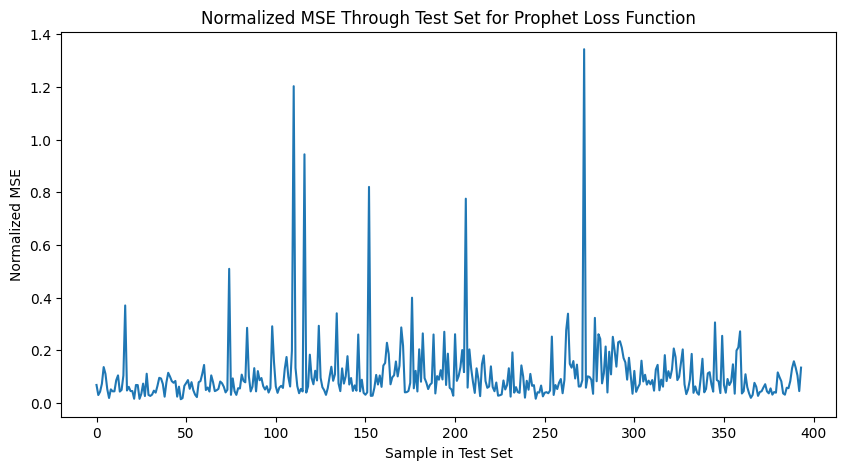

In [16]:
# Compute normalized MSE through samples 
def normalized_mse(actuals, predictions): 
    
    actuals = actuals[10:, :]
    error = np.empty(np.shape(predictions)[0])
    
    for i in range(len(predictions)):
        actual = actuals[i, :]
        predicted = predictions[i, :]

        mse = sum([(a - p) ** 2 for a, p in zip(actual, predicted)]) / len(actual)
        mean_actual = sum(actual) / len(actual)
        normalization_factor = sum([(a - mean_actual) ** 2 for a in actual]) / len(actual)
        nmse = mse / normalization_factor

        error[i] = nmse

    return error 

error = normalized_mse(test_set, preds)

fig, ax = plt.subplots(figsize = (10,5))
ax.plot(error)

ax.set_xlabel('Sample in Test Set')
ax.set_ylabel('Normalized MSE')
ax.set_title('Normalized MSE Through Test Set for Prophet Loss Function')


In [20]:
# Compute the MLU baseline 
G = abilene_topo()
mlu_baseline = np.empty((1, len(preds)))

for i in range(len(preds)):

    D = test_set[i+10, :].reshape(12,12)
    np.fill_diagonal(D, 0)

    u = MinMaxLinkUtil(G, D*0.01)
    mlu_baseline[0,i] = u

# Save baseline
np.save('mlu_abilene_baseline.npy', mlu_baseline)

In [23]:
# Compute the MLU on the predictions 
G = abilene_topo()
mlu_mse = np.empty((1, len(preds)))
for i in range(len(preds)):

    D = preds[i, :].reshape(12,12)
    np.fill_diagonal(D, 0)

    u = MinMaxLinkUtil(G, D*0.01)
    mlu_mse[0,i] = u


# Save MLU on predictions
np.save('mlu_abilene_cosine.npy', mlu_mse)

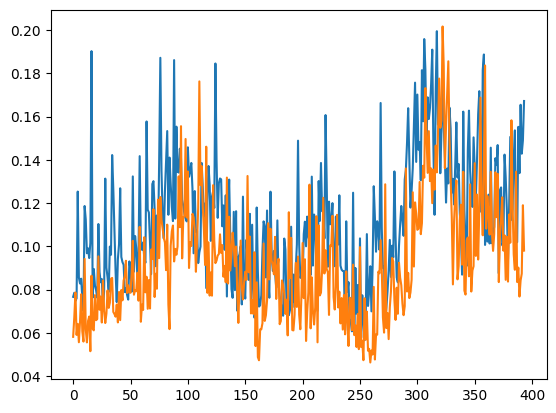

In [24]:
plt.plot(mlu_baseline.reshape(-1,1))
plt.plot(mlu_mse.reshape(-1,1))

Text(0.5, 1.0, 'CDF of MLU Bias -  $\\frac{U^{\\prime}}{U}$ Cosine Similarity Loss Function')

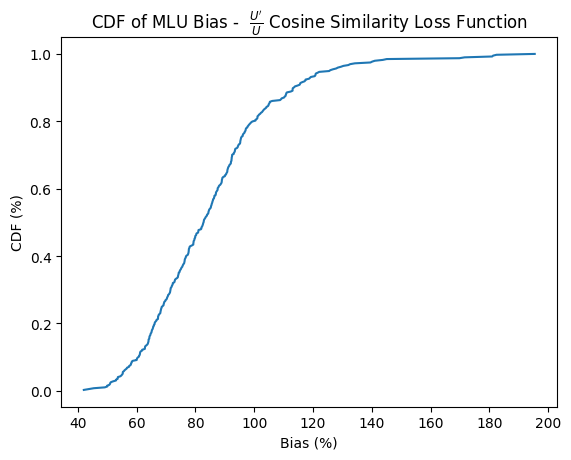

In [25]:
bias = mlu_mse/mlu_baseline
data_size = len(bias)

data = np.reshape(bias*100, (394,))

data_set = sorted(set(data))
bins = np.append(data_set, data_set[-1] + 1)

# Use the histogram function to bin the data
counts, bin_edges = np.histogram(data, bins=bins, density=False)
counts = counts.astype(float) / data_size

# Find the cdf
cdf = np.cumsum(counts*100)
plt.plot(bin_edges[0:-1], cdf/np.max(cdf))
plt.xlabel('Bias (%)')
plt.ylabel('CDF (%)')
plt.title(r'CDF of MLU Bias -  $\frac{U^{\prime}}{U}$ Cosine Similarity Loss Function')

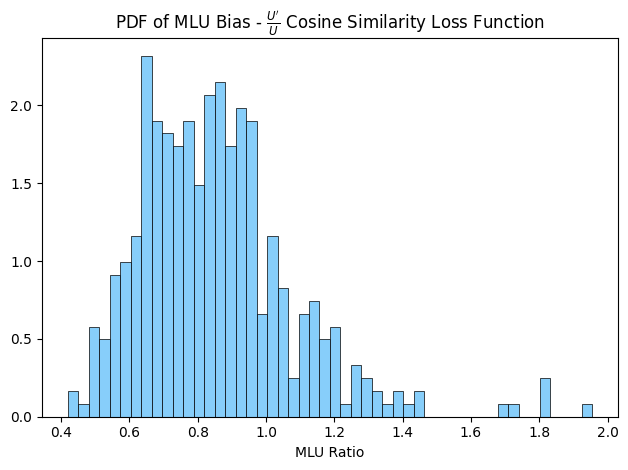

In [26]:
# Compute the pdf 

fig, ax1 = plt.subplots() 
ax1.set_xlabel('MLU Ratio')
ax1.hist(data/100, bins = 50, linewidth = 0.5, edgecolor = 'black', label = 'PDF MLU Bias', density = True, color='lightskyblue')

plt_title = r'PDF of MLU Bias - $\frac{U^{\prime}}{U}$ Cosine Similarity Loss Function'
plt.title(plt_title)

fig.tight_layout()  # otherwise the right y-label is slightly clipped